In [0]:
import requests as rq
from datetime import datetime as dt
import pandas as pd
import numpy as np

In [0]:
API_LINK = "https://api.coindesk.com/v1/bpi/historical/close.json"
start = "2010-07-17"
end = dt.now().strftime("%Y-%m-%d")
URL = API_LINK + "?start=" + start + "&end=" + end

API_Data = rq.get(API_LINK)

PARAMS = {"start":start,
          "end": end} 
r = rq.get(url = API_LINK, params = PARAMS) 
data = r.json()["bpi"]


dates = np.array(list(data.keys()))
dates = np.vectorize(lambda x: dt.strptime(x, "%Y-%m-%d"))(dates)
prices = np.array(list(data.values()))

bitcoin_price = pd.DataFrame({"Date": dates, "ClosePrice": prices})

periods = 1

bitcoin_price["Change"] = bitcoin_price["ClosePrice"].pct_change(periods=periods) * 100.0
bitcoin_price = bitcoin_price.fillna(0)
bitcoin_price

bitcoin_price.to_csv('precios bitcoin.csv')

In [0]:
from bokeh.layouts import gridplot
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import LinearAxis, Range1d
from bokeh.models import ColumnDataSource, RangeTool
from bokeh.layouts import row, column
from bokeh.models.callbacks import CustomJS

x_range = (bitcoin_price["Date"].values[0],bitcoin_price["Date"].values[-1])
y_range = (-1 * max(bitcoin_price["ClosePrice"].values) * 0.01,max(bitcoin_price["ClosePrice"].values) * 1.1)
source = ColumnDataSource(bitcoin_price)

p = figure(tools="pan,wheel_zoom,box_zoom,reset,save",
           title="Bitcoin price in USD",
           x_axis_label="Time", y_axis_label="USD",
           plot_width=600, plot_height=500,
           x_range=x_range,
           x_axis_type='datetime')


pv = figure(tools="pan,wheel_zoom,box_zoom,reset,save",
           title="Bitcoin price percentage change",
           x_axis_label="Time", y_axis_label="Percentage",
           plot_width=600, plot_height=500,
           x_range= p.x_range,
           x_axis_type='datetime')


p.grid.grid_line_alpha=0.3


p.line(bitcoin_price["Date"].values,
       bitcoin_price["ClosePrice"].values,
       color='#A6CEE3',
       legend_label='BTC in US')


select = figure(title="Selector",
                plot_height=200, plot_width=1200,
                x_axis_type="datetime", y_axis_type=None,
                tools="", toolbar_location=None,
                x_range=x_range,
                y_range=y_range)



range_tool = RangeTool(x_range= p.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

select.line(bitcoin_price["Date"].values,
            bitcoin_price["ClosePrice"].values)


select.ygrid.grid_line_color = None
select.add_tools(range_tool)
select.toolbar.active_multi = range_tool


###############################################


def getCallback(data_row, plot):
    return CustomJS(args=dict(yr=plot.y_range, xr=plot.x_range, source=source, row_name=data_row), code="""
                    
                    var x_values = source.data["Date"]
                    var pos_start = x_values.findIndex(function(number) { return number > xr.start;}) - 1;
                    console.log(yr.start)
                    console.log(yr.end)

                    if (pos_start < 0) {
                        pos_start = 0;
                    }
                    
                    var pos_end = x_values.findIndex(function(number) { return number > xr.end;});
                    if (pos_end <= 0) {
                        pos_end = x_values.length;
                    }

                    var y_values = source.data[row_name].slice(pos_start, pos_end);
                    
                    yr.end = Math.max.apply(null, y_values) * 1.1;
                    yr.start = Math.min.apply(null, y_values);
                    
                    if(yr.start < 0){
                        yr.start = yr.start * 1.1;
                    }else{
                        yr.start = -1 * yr.end * 0.01;
                    }
                    
                    """)

# execute a callback whenever p.x_range.start changes
p.x_range.js_on_change('start', getCallback("ClosePrice", p))
p.x_range.js_on_change('end', getCallback("ClosePrice", p))

pv.x_range.js_on_change('start', getCallback("Change", pv))
pv.x_range.js_on_change('end', getCallback("Change", pv))
###############################################



increase = bitcoin_price[bitcoin_price["Change"] > 0.0]
decrease = bitcoin_price[bitcoin_price["Change"] < 0.0]

w = 12*60*60*1000 

pv.vbar(increase["Date"].values, w,
       0.0, increase["Change"].values,
       color='#B2DF8A')

pv.vbar(decrease["Date"].values, w,
       0.0, decrease["Change"].values,
       color='#FB9A99')


#p.vbar(df.date[inc], w, df.open[inc], df.close[inc], fill_color="#D5E1DD", line_color="black")


output_notebook()

#show(p)
show(column(row(p, pv), select))


In [9]:
# base de Nico

import pandas as pd
import datetime
import os.path


class BitcoinHistoricalDataReader:

    SOURCE = r'https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20150419&end=20200519'

    FILENAME = 'Bitcoin Historical Data - Investing.com.csv'

    @classmethod
    def stringDateToDate( cls, strDate ):
        return datetime.datetime.strptime( strDate, "%b %d, %Y")#.date()

    @classmethod
    def strToValues( cls, numAsStr ):
        if numAsStr.endswith('M'): return float( numAsStr[:-1] ) * 1000000
        if numAsStr.endswith('K'): return float( numAsStr[:-1] ) * 1000
        return float( numAsStr )

    @classmethod
    def strToPercentages( cls, precentageStr ):
        return float( precentageStr[:-1] )/100

    @classmethod
    def read( cls, path=r"." ):

        full_path = os.path.join( path, cls.FILENAME )

        df = pd.read_csv(full_path,
                         sep=',',
                         thousands=',',
                         dtype={"Date": str, "Price": float, "Open": float, "High": float, "Low": float, "Vol.": str,
                                "Change %": str})

        df['Date'] = df['Date'].apply( cls.stringDateToDate )
        df['Vol.'] = df['Vol.'].apply( cls.strToValues )
        df['Change %'] = df['Change %'].apply( cls.strToPercentages )

        return df

df = BitcoinHistoricalDataReader.read()

print(df.head())
print(df.dtypes)

        Date   Price    Open    High     Low       Vol.  Change %
0 2020-05-19  9662.7  9730.8  9883.9  9498.7  1150000.0   -0.0070
1 2020-05-18  9730.7  9678.4  9930.2  9524.4  1180000.0    0.0055
2 2020-05-17  9677.7  9376.6  9866.0  9327.8  1180000.0    0.0318
3 2020-05-16  9379.5  9318.1  9579.0  9233.0  1100000.0    0.0066
4 2020-05-15  9318.0  9778.6  9819.6  9223.2  1560000.0   -0.0471
Date        datetime64[ns]
Price              float64
Open               float64
High               float64
Low                float64
Vol.               float64
Change %           float64
dtype: object


In [10]:
#!pip install ta

import ta

# ordenamos la base para que calcule bien los indicadores

df = df.sort_values('Date')

## generamos indicadores por categorias

s = 7
l = 14

## momentos
df['p_mom_aoi'] = ta.momentum.AwesomeOscillatorIndicator(df.High, df.Low, s = s, len = l, fillna = False).ao()
df['p_mom_kama'] = ta.momentum.KAMAIndicator(df.Price, n= l, pow1= 2, pow2= 30, fillna= False).kama()
df['p_mom_roc'] = ta.momentum.roc(df.Price, n=s, fillna=False)
df['p_mom_rsi'] = ta.momentum.rsi(df.Price, n=s, fillna=False)
df['p_mom_tsi'] = ta.momentum.tsi(df.Price, r=l, s=s, fillna=False)
df['p_mom_so'] = ta.momentum.StochasticOscillator(df.High, df.Low, df.Price, n = l, d_n = 3, fillna= False).stoch()
df['p_mom_so_sig'] = ta.momentum.StochasticOscillator(df.High, df.Low, df.Price, n = l, d_n = 3, fillna= False).stoch_signal()
df['p_mom_w%RI'] = ta.momentum.WilliamsRIndicator(df.High, df.Low, df.Price, lbp = l, fillna = False).wr()
df['p_mom_so'] = ta.momentum.stoch(df.High, df.Low, df.Price, n=l, d_n=3, fillna=False)
df['p_mom_sos'] =ta.momentum.stoch_signal(df.High, df.Low, df.Price, n=l, d_n=3, fillna=False)

## volumen
df['v_adii'] = ta.volume.AccDistIndexIndicator(df.High, df.Low,df.Price, df['Vol.'], fillna = False).acc_dist_index()
df['v_cmfi'] = ta.volume.ChaikinMoneyFlowIndicator(df.High, df.Low, df.Price, df['Vol.'], n = l, fillna = False).chaikin_money_flow()
df['v_ami'] = ta.volume.EaseOfMovementIndicator(df.High, df.Low, df['Vol.'], n = l, fillna= False).ease_of_movement()
df['v_ami_sma'] = ta.volume.EaseOfMovementIndicator(df.High, df.Low, df['Vol.'], n = l, fillna = False).sma_ease_of_movement()
df['v_fii'] = ta.volume.ForceIndexIndicator(df.Price, df['Vol.'], n = l, fillna = False).force_index()
df['v_mfii'] = ta.volume.MFIIndicator(df.High, df.Low,df.Price, df['Vol.'], n = l, fillna = False).money_flow_index()
df['v_nvii'] = ta.volume.NegativeVolumeIndexIndicator(df.Price, df['Vol.'], fillna = False).negative_volume_index()
df['v_vpti'] = ta.volume.VolumePriceTrendIndicator(df.Price, df['Vol.'], fillna = False).volume_price_trend()
df['v_vwap'] = ta.volume.VolumeWeightedAveragePrice(df.High, df.Low,df.Price, df['Vol.'], n = l, fillna = False).volume_weighted_average_price()
df['v_mm_short_mavg'] = df['Vol.'].rolling(window=s, min_periods=1, center=False).mean()
df['v_mm_short_sum'] = df['Vol.'].rolling(window=s, min_periods=1, center=False).sum()
df['v_mm_long_mavg'] = df['Vol.'].rolling(window=l, min_periods=1, center=False).mean()
df['v_mm_long_sum'] = df['Vol.'].rolling(window=l, min_periods=1, center=False).sum()

## volatibilidad

# Initialize Bollinger Bands Indicator
indicator_bb = ta.volatility.BollingerBands(close=df["Price"], n=l, ndev=1.5)
# Add Bollinger Bands features
df['p_vol_bb_bbm'] = indicator_bb.bollinger_mavg()
df['p_vol_bb_bbh'] = indicator_bb.bollinger_hband()
df['p_vol_bb_bbl'] = indicator_bb.bollinger_lband()

# Initialize Bollinger Bands Indicator
indicator_bb = ta.volatility.BollingerBands(close=df["Price"], n=s, ndev=1)
# Add Bollinger Bands features
df['p_vol_bb_bbm_corto'] = indicator_bb.bollinger_mavg()
df['p_vol_bb_bbh_corto'] = indicator_bb.bollinger_hband()
df['p_vol_bb_bbl_corto'] = indicator_bb.bollinger_lband()

# desvio y varianza
df['p_sd_s'] = df['Price'].rolling(window=s, min_periods=1, center=False).std()
df['p_sd_l'] = df['Price'].rolling(window=l, min_periods=1, center=False).std()
df['p_var_s'] = df['Price'].rolling(window=s, min_periods=1, center=False).var()
df['p_var_l'] = df['Price'].rolling(window=s, min_periods=1, center=False).var()

df['p_vol_atr'] = ta.volatility.AverageTrueRange(df.High, df.Low, df.Price, n = l, fillna = False).average_true_range()
df['p__vol_dc'] =  ta.volatility.DonchianChannel(df.High, df.Low, df.Price, n = l, offset = 0, fillna = False).donchian_channel_mband()

## tendencia

adxi = ta.trend.ADXIndicator(df.High, df.Low, df.Price, n = l, fillna = False)
df['p_tend_adxi'] = adxi.adx()
df['p_tend_adxi_neg'] = adxi.adx_neg()
df['p_tend_adxi_pos'] = adxi.adx_pos()
df['p_tend_ccii'] = ta.trend.CCIIndicator(df.High, df.Low, df.Price, n = l, c = 0.015, fillna = False).cci()
df['p_tend_mi'] = ta.trend.MassIndex(df.High, df.Low, n = s, n2 = l, fillna = False).mass_index()

vi = ta.trend.VortexIndicator(df.High, df.Low, df.Price, n = l, fillna = False)
df['p_tend_vi_dif'] = vi.vortex_indicator_diff()
df['p_tend_vineg'] = vi.vortex_indicator_neg()
df["p_tend_vi_pos"] = vi.vortex_indicator_pos()

df['p_tend_cci'] = ta.trend.cci(df.High, df.Low, df.Price, n=l, c=0.015, fillna=False)

aroon = ta.trend.AroonIndicator(df.Price, n = l, fillna= False)
df['p_tend_aroon_down'] = aroon.aroon_down() 
df['p_tend_aroon_ind'] = aroon.aroon_indicator()
df['p_tend_aroon_up'] = aroon.aroon_up()

df['p_tend_dpo'] = ta.trend.DPOIndicator(df.Price, n = l, fillna = False).dpo()
df['p_tend_ema'] = ta.trend.EMAIndicator(df.Price, n = l, fillna = False).ema_indicator()
df['p_tend_sma'] = ta.trend.SMAIndicator(df.Price, n = l, fillna = False).sma_indicator()
df['p_tend_macd'] = ta.trend.macd(df.Price, n_slow=26, n_fast=l, fillna=False)
df['p_tend_trix'] = ta.trend.trix(df.Price, n=l, fillna=False)

## medias moviles

# Initialize the short and long windows
short_window = 10
long_window = 30

df['p_mm_signal'] = 0.0

# Create short simple moving average over the short window
df['p_mm_short_mavg'] = df['Price'].rolling(window=short_window, min_periods=1, center=False).mean()
df['p_mm_short_sum'] = df['Price'].rolling(window=short_window, min_periods=1, center=False).sum()

# Create long simple moving average over the long window
df['p_mm_long_mavg'] = df['Price'].rolling(window=long_window, min_periods=1, center=False).mean()
df['p_mm_long_mavg'] = df['Price'].rolling(window=long_window, min_periods=1, center=False).sum()

# Create signals
df['p_mm_signal'][short_window:] = np.where(df['p_mm_short_mavg'][short_window:] 
                                            > df['p_mm_long_mavg'][short_window:], 1.0, 0.0)   

# otros
df['p_otros_trix'] = ta.others.CumulativeReturnIndicator(df.Price, fillna = False).cumulative_return()
df['p_otros_dri'] = ta.others.DailyReturnIndicator(df.Price, fillna = False).daily_return()

# ventana de variaciones
df["p_variacion_3"] = df["Price"].pct_change(periods=3) * 100.0
df["p_variacion_7"] = df["Price"].pct_change(periods=7) * 100.0

# variables sobre la variacion diaria

short_window = 3
medium_window = 7
long_window = 15

df['ch_short_mavg'] = df['Change %'].rolling(window=short_window, min_periods=1, center=False).mean()
df['ch_short_sum'] = df['Change %'].rolling(window=short_window, min_periods=1, center=False).sum()

df['ch_short_mavg'] = df['Change %'].rolling(window=medium_window, min_periods=1, center=False).mean()
df['ch_short_sum'] = df['Change %'].rolling(window=medium_window, min_periods=1, center=False).sum()

df['ch_long_mavg'] = df['Change %'].rolling(window=long_window, min_periods=1, center=False).mean()
df['ch_long_mavg'] = df['Change %'].rolling(window=long_window, min_periods=1, center=False).sum()

/usr/local/lib/python3.6/dist-packages/ta/trend.py:608: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:612: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
# variable a predecir
df["Y_reg"] = df["Change %"].shift(-1)

df['Y_clas'] = np.where(df['Y_reg']<=-0.005, -1, np.where(df['Y_reg']>=0.005,1,0))

df.to_csv('precios bitcoin proc.csv')


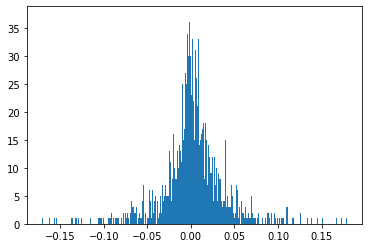

In [14]:
# definimos clase

import matplotlib.pyplot as plt
graf = plt.hist(df[(df.Y_reg < 0.2) & (df.Y_reg > -0.2)].Y_reg,500)

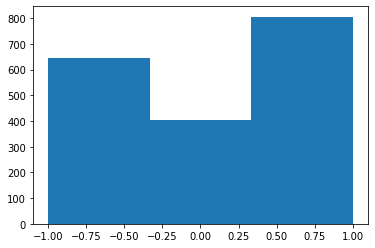

In [15]:
graf = plt.hist(df.Y_clas,3)

In [0]:
from google.colab import drive
drive.mount('/content/drive')